2017

Machine Learning Practical

University of Edinburgh

Georgios Pligoropoulos - s1687568

Coursework 4 (part 4)

### Imports, Inits, and helper functions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
jupyterNotebookEnabled = True
plotting = True

coursework, part = 4, 4
saving = True

In [3]:
import sys, os
mlpdir = os.path.expanduser(
    '~/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical'
)
sys.path.append(mlpdir)

In [4]:
from collections import OrderedDict
from __future__ import division
import skopt
from mylibs.jupyter_notebook_helper import show_graph
import datetime
import time
import tensorflow as tf
import numpy as np
from mlp.data_providers import MSD10GenreDataProvider, MSD25GenreDataProvider,\
    MSD10Genre_Autoencoder_DataProvider, MSD10Genre_StackedAutoEncoderDataProvider
import matplotlib.pyplot as plt
%matplotlib inline
from mylibs.batch_norm import fully_connected_layer_with_batch_norm_and_l2
from mylibs.stacked_autoencoder_pretrainer import \
    constructModelFromPretrainedByAutoEncoderStack,\
    buildGraphOfStackedAutoencoder, executeNonLinearAutoencoder
    
from mylibs.jupyter_notebook_helper import getRunTime, getTrainWriter, getValidWriter,\
    plotStats, initStats, gatherStats, renderStatsCollection
    
from mylibs.tf_helper import tfRMSE, tfMSE, fully_connected_layer, \
    trainEpoch, validateEpoch

from mylibs.py_helper import merge_dicts, factors

from mylibs.dropout_helper import constructProbs

from mylibs.batch_norm import batchNormWrapper_byExponentialMovingAvg,\
    fully_connected_layer_with_batch_norm
    
from skopt.space.space import Integer, Categorical
from skopt import gp_minimize

import pickle

from rnn.msd10_data_providers import MSD10Genre_120_rnn_native_DataProvider
from rnn.advanced_rnn import AdvancedRNN

In [5]:
seed = 16011984
rng = np.random.RandomState(seed=seed)

config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth = True

figcount = 0

tensorboardLogdir = 'tf_cw{}_{}'.format(coursework, part)

curDtype = tf.float32

reluBias = 0.1

batch_size = 50

### MSD 10 genre task

In [6]:
segmentCount = 120
segmentLen = 25

https://www.tensorflow.org/versions/r0.12/api_docs/python/nn/recurrent_neural_networks#rnn

In [7]:
advancedRNN = AdvancedRNN(batch_size=batch_size, rng=rng, dtype=curDtype, config=config,
                          segment_count=segmentCount, segment_len = segmentLen)

In [8]:
show_graph(
    advancedRNN.loadAndGetGraph(num_steps=4, state_size=15, numOfLastToCombine=5, stride=2)
)

### Exploration of best parameters: state size, num of RNN steps, number of last to combine and stride with Bayesian Optimization

In [10]:
steps_possible = np.sort(factors(segmentCount))[1:-1]
assert np.all( segmentCount % steps_possible == 0 )
steps_possible = steps_possible[steps_possible >= 4]
print len(steps_possible)
steps_possible

12


array([ 4,  5,  6,  8, 10, 12, 15, 20, 24, 30, 40, 60])

In [11]:
stateSizeSpace = Integer(200, 500)
numStepSpace = Categorical(steps_possible)
numOfLastToCombineSpace = Integer(1, 60)
strideSpace = Integer(1, 10)
space  = [stateSizeSpace, numStepSpace, numOfLastToCombineSpace, strideSpace]

In [12]:
res_gp_save_filename = 'rnn_advanced_res_gp.pickle'
best_params_filename = 'rnn_advanced_best_params.npy'
statsCollectionFilename = 'rnn_advanced_bay_opt_stateSize_numSteps_statsCollection.npy'

In [15]:
def objective(params): # Here we define the metric we want to minimise    
    (state_size, num_steps, num_of_last_to_combine, stride) = params
    
    stats, keys = advancedRNN.rnn_native_tf(
        epochs = 20,
        state_size = state_size,
        num_steps = num_steps,
        num_of_last_to_combine = num_of_last_to_combine,
        stride = stride,
    )
    
    if plotting:
        fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
        plt.show()
    
    #save everytime in case it crashes
    filename = statsCollectionFilename
    statsCollection = np.load(filename)[()] if os.path.isfile(filename) else dict()
    statsCollection[tuple(params)] = stats
    np.save(filename, statsCollection)
    
    # We want to maximise validation accuracy, i.e. minimise minus validation accuracy
    validAccs = stats[:, -1]
    length10percent = len(validAccs) // 10
    best10percent = np.sort(validAccs)[-length10percent:]
    return -np.mean(best10percent)

number of last rnn outputs to combine: 31
stride: 10
epochs: 20
rnn steps: 6
state size: 303
End epoch 01 (22.757 secs): err(train)=2.30, acc(train)=0.10, err(valid)=2.30, acc(valid)=0.10, 
End epoch 02 (21.648 secs): err(train)=2.30, acc(train)=0.10, err(valid)=2.30, acc(valid)=0.10, 
End epoch 03 (21.578 secs): err(train)=2.30, acc(train)=0.10, err(valid)=2.30, acc(valid)=0.10, 
End epoch 04 (21.856 secs): err(train)=2.30, acc(train)=0.10, err(valid)=2.30, acc(valid)=0.10, 
End epoch 05 (22.367 secs): err(train)=2.30, acc(train)=0.10, err(valid)=2.30, acc(valid)=0.10, 
End epoch 06 (22.403 secs): err(train)=2.30, acc(train)=0.10, err(valid)=2.30, acc(valid)=0.10, 
End epoch 07 (22.125 secs): err(train)=2.30, acc(train)=0.10, err(valid)=2.30, acc(valid)=0.10, 
End epoch 08 (22.746 secs): err(train)=2.30, acc(train)=0.10, err(valid)=2.30, acc(valid)=0.10, 
End epoch 09 (22.213 secs): err(train)=2.30, acc(train)=0.10, err(valid)=2.30, acc(valid)=0.10, 
End epoch 10 (22.021 secs): err(tr

/home/studenthp/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical/mylibs/jupyter_notebook_helper.py:74: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax_1.hold(True)
/home/studenthp/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical/mylibs/jupyter_notebook_helper.py:78: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax_1.hold(False)
/home/studenthp/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical/mylibs/jupyter_notebook_helper.py:87: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax_2.hold(True)
/home/studenthp/pligor.george@gma

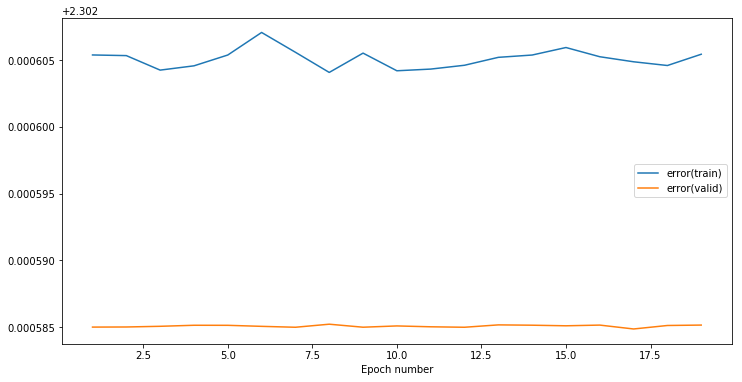

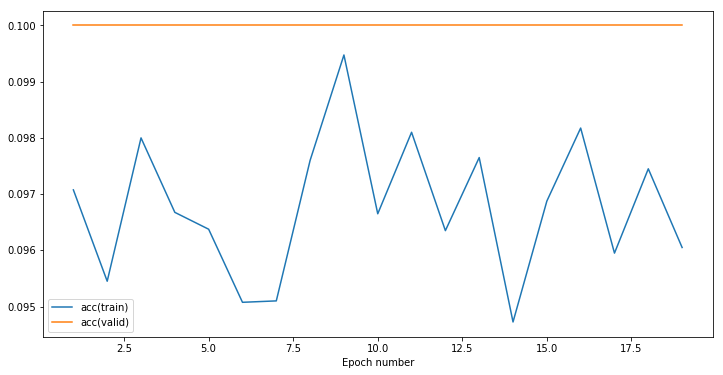

TypeError: unhashable type: 'list'

In [14]:
%%time

if not os.path.isfile(best_params_filename):
    res_gp = gp_minimize(
            func=objective, # function that we wish to minimise
            dimensions=space, #the search space for the hyper-parameters
            #x0=x0, #inital values for the hyper-parameters
            n_calls=50, #number of times the function will be evaluated
            random_state = seed, #random seed
            n_random_starts=5,
                #before we start modelling the optimised function with a GP Regression
                #model, we want to try a few random choices for the hyper-parameters.
            kappa=1.9 #trade-off between exploration vs. exploitation.
        )

In [ ]:
if os.path.isfile(best_params_filename):
    best_params = np.load(best_params_filename)
else:
    np.save(best_params_filename, res_gp.x)
    best_params = res_gp.x

In [ ]:
if os.path.isfile(res_gp_save_filename):
    with open(res_gp_save_filename) as f:  # Python 3: open(..., 'rb')
        (res_gp, ) = pickle.load(f)
else:
    with open(res_gp_save_filename, 'w') as f:  # Python 3: open(..., 'wb')
        pickle.dump([res_gp], f)

In [ ]:
best_params

In [ ]:
from skopt.plots import plot_convergence

In [ ]:
if plotting:
    fig = plt.figure(figsize=(12,6))
    plot_convergence(res_gp)
    plt.grid()
    plt.show()
    if saving:
        fig.savefig('cw{}_part{}_fig_convergence_plot.svg'.format(coursework, part))

In [ ]:
if plotting:
    fig = plt.figure(figsize=(12,6))
    plt.plot(np.arange(len(res_gp.func_vals))+1, res_gp.func_vals)
    plt.scatter(np.arange(len(res_gp.func_vals))+1, res_gp.func_vals)
    plt.ylabel(r'$f(x)$')
    plt.xlabel('Number of calls $n$')
    plt.xlim([0, len(res_gp.func_vals)])
    plt.show()
    if saving:
        fig.savefig('cw{}_part{}_fig_bayes_func.svg'.format(coursework, part))

In [ ]:
statsCollection = np.load(statsCollectionFilename)[()]

In [ ]:
key = "error(train)"
fig = renderStatsCollection(statsCollection, epochs = 30, title = "Training Error",
                      k = key)
if saving:
    fig.savefig('cw{}_part{}_fig_bayes_opt_{}.svg'.format(coursework, part, key))

In [ ]:
key = "error(valid)"
fig = renderStatsCollection(statsCollection, epochs = 30, title = "Validation Error",
                      k = key)
if saving:
    fig.savefig('cw{}_part{}_fig_bayes_opt_{}.svg'.format(coursework, part, key))

In [ ]:
key = "acc(train)"
fig = renderStatsCollection(statsCollection, epochs = 30, title = "Training Accuracy",
                      k = key)
if saving:
    fig.savefig('cw{}_part{}_fig_bayes_opt_{}.svg'.format(coursework, part, key))

In [ ]:
key = "acc(valid)"
fig = renderStatsCollection(statsCollection, epochs = 30, title = "Validation Accuracy",
                      k = key)
if saving:
    fig.savefig('cw{}_part{}_fig_bayes_opt_{}.svg'.format(coursework, part, key))

## Train best parameters classifier with native tensorflow RNN

In [8]:
%%time

#(state_size, num_steps) = best_params

stats, keys = advancedRNN.rnn_native_tf(
        epochs = 20,
        state_size = 100,
        num_steps = 30,
        num_of_last_to_combine = 10,
        stride = 2,
    )

if plotting:
    fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
    plt.show()      
    if saving:
        figcount += 1
        fig_1.savefig('cw{}_part{}_{:02d}_fig_error.svg'.format(coursework, part, figcount))
        fig_2.savefig('cw{}_part{}_{:02d}_fig_valid.svg'.format(coursework, part, figcount))

number of last rnn outputs to combine: 10
stride: 2
epochs: 20
rnn steps: 30
state size: 100


AssertionError: 

In [ ]:
print max(stats[:, -1])

In [9]:
[3, 4] + [ 45]

[3, 4, 45]